<a href="https://colab.research.google.com/github/luishpinto/cm-hydraulic-data-set/blob/master/cnn_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os.path

if not os.path.exists('TS1.txt'):
  !wget -O 'TS1.txt' 'https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/TS1.txt'

if not os.path.exists('TS2.txt'):
  !wget -O 'TS2.txt' 'https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/TS2.txt'

if not os.path.exists('TS3.txt'):
  !wget -O 'TS3.txt' 'https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/TS3.txt'

if not os.path.exists('TS4.txt'):
  !wget -O 'TS4.txt' 'https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/TS4.txt'

if not os.path.exists('profile.txt'):
  !wget -O 'profile.txt' 'https://github.com/luishpinto/cm-hydraulic-data-set/raw/master/profile.txt'


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 12

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [0]:
%tensorflow_version 1.x
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

In [0]:
def normalize(df):
  return (df - df.mean(axis = 0)) / df.std(axis = 0)

In [0]:
def plotConfusionMatrix(dtrue,dpred,classes,\
                        cmap = plt.cm.Blues,bsize = 1.0):
  
  cm = confusion_matrix(dtrue,dpred,normalize = 'true')
  
  fig,ax = plt.subplots(figsize = (np.shape(classes)[0] * 1.25 * bsize,\
                                   np.shape(classes)[0] * 1.25 * bsize))
  im = ax.imshow(cm,interpolation = 'nearest',cmap = cmap)
  
  ax.set(xticks = np.arange(cm.shape[1]),
         yticks = np.arange(cm.shape[0]),
         xticklabels = classes,
         yticklabels = classes,
         ylabel = 'True Efficiency',
         xlabel = 'Predicted Efficiency')
  
  plt.setp(ax.get_xticklabels(),rotation = 90,ha = 'right',
           rotation_mode = 'anchor')

  fmt = '.2f'

  thresh = cm.max() / 2.0
  
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j,i,format(cm[i,j],fmt),ha = 'center',va = 'center',
              color = 'white' if cm[i,j] > thresh else 'black')
      
  fig.tight_layout()
  
  return ax

In [26]:
label = pd.read_csv('profile.txt',sep = '\t',header = None)
label = to_categorical(label[0].factorize()[0])

print('Label shape = {}'.format(label.shape))

Label shape = (2205, 3)


In [27]:
data = ['TS1.txt','TS2.txt','TS3.txt','TS4.txt']

df = pd.DataFrame()

for i in data:
  df = df.append(pd.read_csv(i,sep = '\t',header = None))

df = df.apply(normalize)
df = df.sort_index().values.reshape(-1,4,60).transpose(0,2,1)

print('DataFrame shape = {}'.format(df.shape))

DataFrame shape = (2205, 60, 4)


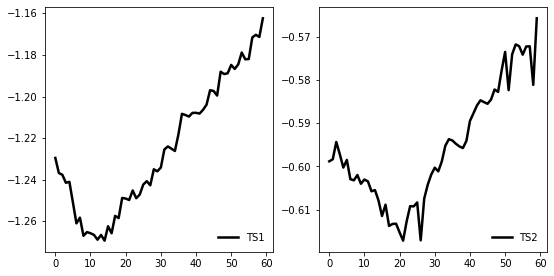

In [28]:
matplotlib.rcParams['font.size'] = 10

plt.subplots(1,2,figsize = (9.0,4.5),sharex = True)
for i in range(2):
  plt.subplot(1,2,(i + 1))
  plt.plot(df[0][:,i],color = 'black',lw = 2.50)
  plt.legend(['TS' + str(i + 1)],frameon = False,loc = 'lower right')
plt.savefig('fig-1.ps',dpi = 300,format = 'ps')
plt.show()

In [0]:
xtrain,xtest,ytrain,ytest = train_test_split(df,label,\
                                             random_state = 42,\
                                             test_size = 0.2)

In [30]:
periods,sensors = 60,4

mdl = Sequential()
mdl.add(Conv1D(100,6,activation = 'relu',\
               input_shape = (periods,sensors)))
mdl.add(Conv1D(100,6,activation = 'relu'))
mdl.add(MaxPooling1D(3))
mdl.add(Conv1D(160,6,activation = 'relu'))
mdl.add(Conv1D(160,6,activation = 'relu'))
mdl.add(GlobalAveragePooling1D())
mdl.add(Dropout(0.5))
mdl.add(Dense(3,activation = 'softmax'))

print(mdl.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 55, 100)           2500      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 100)           60100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 100)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 11, 160)           96160     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 6, 160)            153760    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 160)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)              

In [0]:
mdl.compile(loss = 'categorical_crossentropy',\
            optimizer = 'adam',metrics = ['accuracy'])

In [0]:
batch,epoch = 32,25

hist = mdl.fit(xtrain,ytrain,batch_size = batch,\
               epochs = epoch,validation_split = 0.2,verbose = 0)

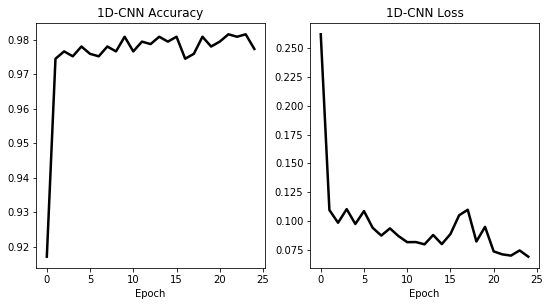

In [33]:
matplotlib.rcParams['font.size'] = 10

plt.subplots(1,2,figsize = (9.0,4.5),sharex = True)
plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['acc'],\
         color = 'black',lw = 2.50)
plt.title('1D-CNN Accuracy')
plt.xlabel('Epoch')
plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],\
         color = 'black',lw = 2.50)
plt.title('1D-CNN Loss')
plt.xlabel('Epoch')
#plt.tight_layout()
plt.savefig('fig-3.ps',dpi = 300,format = 'ps')
plt.show()

In [34]:
print(mdl.evaluate(xtest,ytest,verbose = 2))

441/441 - 0s - loss: 0.1751 - acc: 0.9909
[0.17507606025050287, 0.9909297]


In [35]:
print(classification_report(np.where(ytest != 0)[1],\
                            mdl.predict_classes(xtest)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       152
           1       0.97      1.00      0.99       135
           2       1.00      0.99      0.99       154

    accuracy                           0.99       441
   macro avg       0.99      0.99      0.99       441
weighted avg       0.99      0.99      0.99       441



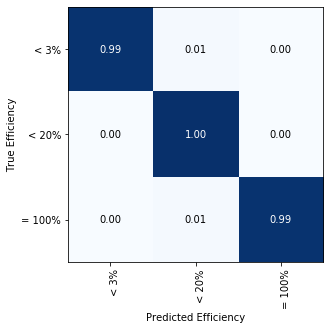

In [36]:
matplotlib.rcParams['font.size'] = 10

plotConfusionMatrix(np.argmax(ytest,axis = 1),\
                    np.argmax(mdl.predict(xtest),axis = 1),\
                    ['< 3%','< 20%','= 100%'],\
                    bsize = 1.25)
plt.savefig('fig-4.ps',dpi = 300,format = 'ps')
plt.show()